In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels.api as sm
import pandasql as ps

warnings.filterwarnings('ignore')

In [2]:
bd = pd.read_csv('final.csv')

In [3]:
bd['finish_dttm'] = pd.to_datetime(bd['finish_dttm'])
bd['age'] = bd['age'].str.replace(',', '.').astype(float)
bd['flag'] = (bd['wo_hit_status_result_desc'] == 'Дозвон, Успешно')
bd['flag'] = bd['flag'].astype(int)

In [4]:
def vibrosi(bd, i, x):
    return pd.concat([bd[bd[i] < x], bd[bd[i].isna()]])
def vibrosiVniz(bd, i, x):
    return pd.concat([bd[bd[i] > x], bd[bd[i].isna()]])
def percentsByRegion(bd, i):
    df = bd.copy()
    pt = df[df['region_size'] == i][df['age'] >= 18][df['age'] < 60][['age', 'flag']].pivot_table(index='age', columns='product_cd', values='flag', aggfunc=['sum', 'count'])
    # pt['percent'] = pt[(  'sum', 'flag')] / pt[('count', 'flag')] * 100
    # pt[pt['percent'] != 0]

In [5]:
bd['child_flg'] = bd['child_amt'] != 0
bd['child_flg'] = bd['child_flg'].astype(int)

In [6]:
bd = vibrosi(bd, 'confirmed_income', 40000)
bd = vibrosi(bd, 'predicted_income', 45000)
bd = vibrosiVniz(bd, 'predicted_income', 0)
bd = vibrosiVniz(bd, 'age', 14)
# хочу делить по: age, auto_flg, partnership_flg, child_flg, realty_type, functional_cd, emp_work_months_cnt, emp_gender_cd, emp_age

df = bd.drop(bd[bd['wo_hit_status_reason_desc'].isin(['Отказ прослушать предложение', 'Не звонить', 'Левый контакт', 'Отказ от диалога', 'отказ от диалога', 'Отказ от разговора', 'Не звонить, резкий негатив', 'Негатив/Не звонить', 'Отказ без объяснения причин', 'просит не звонить', 'Не звонить / резкий негатив', 'Вежливо попросил не звонить', 'Номер не принадлежит страхователю', 'отказ без объяснения причин', 'Отказался озвучить причину', 'Чёрный список', 'негатив к Тинькофф', 'Грубо попросил не звонить', 'Не звонить (негатив)', 'Отказался от диалога', 'Просит больше не звонить', 'Недозвон', 'некорректная заявка', 'Техническая ошибка', 'Не нравится Т-Банк', 'Негатив к Т-Банку', 'Негативная информация о клиенте', 'Отказ без объяснения причины', 'Неизвестен / Не контактирует', 'Человек не участвовал в Дано', 'отменили'])].index)

df['income'] = df['confirmed_income'].fillna(df['predicted_income'])

In [9]:
cc_clients = df[df['product_cd'] == 'Credit Cards']

In [10]:
q4 = """
SELECT * FROM cc_clients
WHERE "Unnamed: 0" NOT IN (
    SELECT "Unnamed: 0" FROM cc_clients
    WHERE "wo_hit_status_reason_desc" IN (
        "Третье лицо", "Другое", "Другой банк", "Карту навязали",
        "Заявку не оставлял", "Другое (нестандартная ситуация)",
        "Кредит / КК в другом банке", "Отказ предоставить персональные данные",
        "Другое (укажи в комментарии)", "Не соответствует по возрасту",
        "Пользуюсь другим антивирусом", "Некорректный трансфер"
    ) 
)
"""

cc_clients = ps.sqldf(q4, locals())

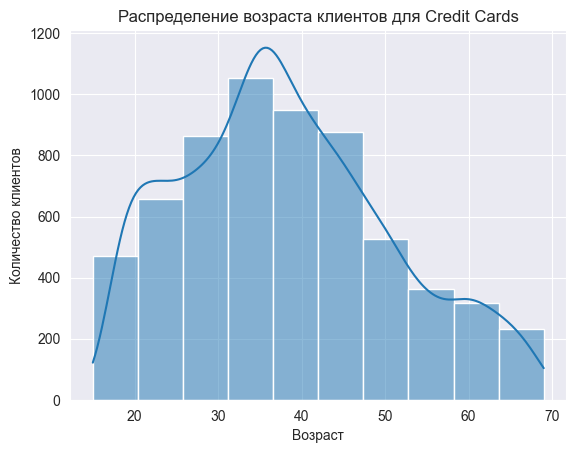

Средний возраст: 38.33
Медианный возраст: 37.00


In [11]:
sns.histplot(cc_clients[cc_clients['age'] < 70]['age'], bins=10, kde=True)
plt.title('Распределение возраста клиентов для Credit Cards')
plt.xlabel('Возраст')
plt.ylabel('Количество клиентов')
plt.show()

mean_age = cc_clients['age'].mean()
median_age = cc_clients['age'].median()

print(f"Средний возраст: {mean_age:.2f}")
print(f"Медианный возраст: {median_age:.2f}")


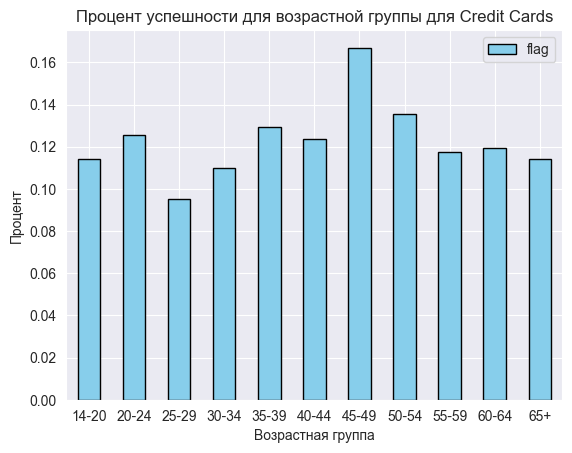

In [12]:
percent_by_age = cc_clients[cc_clients['age'] < 70][['age', 'flag']].copy()
percent_by_age = percent_by_age[np.isfinite(percent_by_age['age'])]
percent_by_age['age'] = (percent_by_age['age'] // 5 * 5).astype(int)
percent_by_age = percent_by_age.groupby('age').mean()

ax = percent_by_age.plot(kind='bar', color='skyblue', edgecolor='black')
labels = ['14-20'] + [(str(i) + '-' + str(i + 4)) for i in range(20, 65, 5)] + ['65+']
ax.set_xticklabels(labels, rotation=0)
plt.title("Процент успешности для возрастной группы для Credit Cards")
plt.xlabel("Возрастная группа")
plt.ylabel("Процент")
plt.show()

Распределение по полу:
gender_cd
M    50.927541
F    49.072459
Name: proportion, dtype: float64


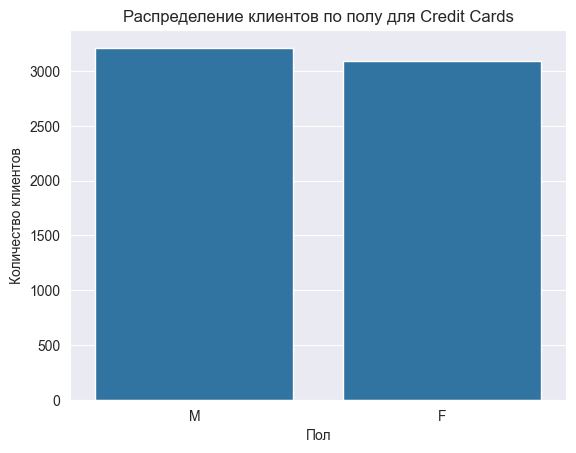

In [13]:
# Распределение по полу
gender_distribution = cc_clients['gender_cd'].value_counts(normalize=True) * 100

print("Распределение по полу:")
print(gender_distribution)

# Визуализация
sns.countplot(x='gender_cd', data=cc_clients)
plt.title('Распределение клиентов по полу для Credit Cards')
plt.xlabel('Пол')
plt.ylabel('Количество клиентов')
plt.show()


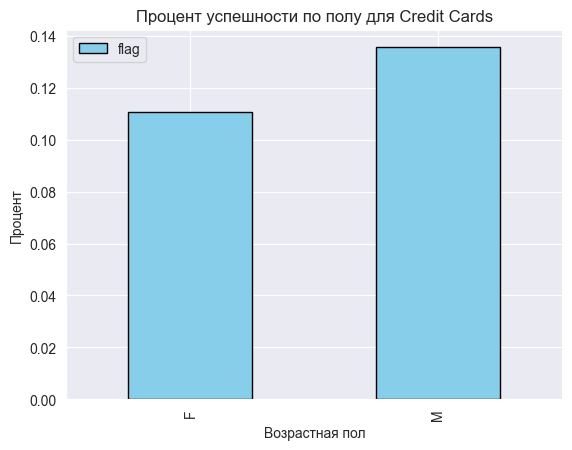

In [14]:
percent_by_gender = cc_clients[['flag', 'gender_cd']].copy()
# percent_by_gender = percent_by_gender[np.isfinite(percent_by_gender['gender_cd'])]
percent_by_gender = percent_by_gender.groupby('gender_cd').mean()

ax = percent_by_gender.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Процент успешности по полу для Credit Cards")
plt.xlabel("Возрастная пол")
plt.ylabel("Процент")
plt.show()

Распределение по количеству детей:
child_amt
0.0    72.317263
1.0    22.032141
2.0     4.561949
3.0     0.959046
4.0     0.103681
5.0     0.025920
Name: proportion, dtype: float64


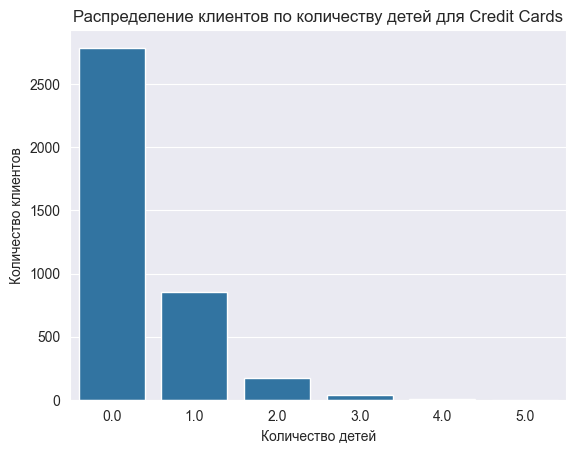

In [15]:
# Распределение по количеству детей
child_distribution = cc_clients['child_amt'].value_counts(normalize=True) * 100

print("Распределение по количеству детей:")
print(child_distribution)

# Визуализация
sns.countplot(x='child_amt', data=cc_clients)
plt.title('Распределение клиентов по количеству детей для Credit Cards')
plt.xlabel('Количество детей')
plt.ylabel('Количество клиентов')
plt.show()

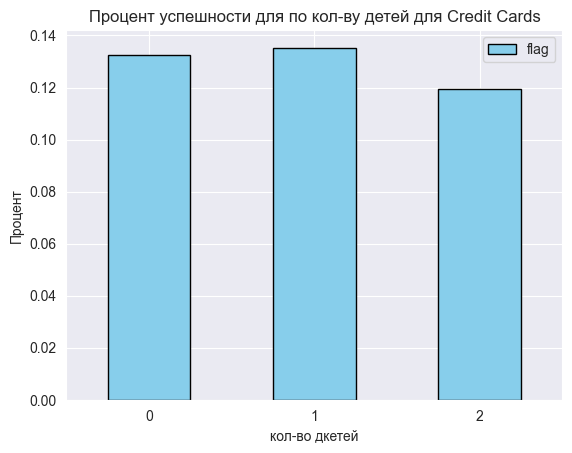

In [16]:
percent_by_child_cnt = cc_clients[cc_clients['child_amt'] < 3][['child_amt', 'flag']].copy()
percent_by_child_cnt = percent_by_child_cnt[np.isfinite(percent_by_child_cnt['child_amt'])]
percent_by_child_cnt = percent_by_child_cnt.groupby('child_amt').mean()

ax = percent_by_child_cnt.plot(kind='bar', color='skyblue', edgecolor='black')
labels = [0, 1, 2]
ax.set_xticklabels(labels, rotation=0)
plt.title("Процент успешности для по кол-ву детей для Credit Cards")
plt.xlabel("кол-во дкетей")
plt.ylabel("Процент")
plt.show()

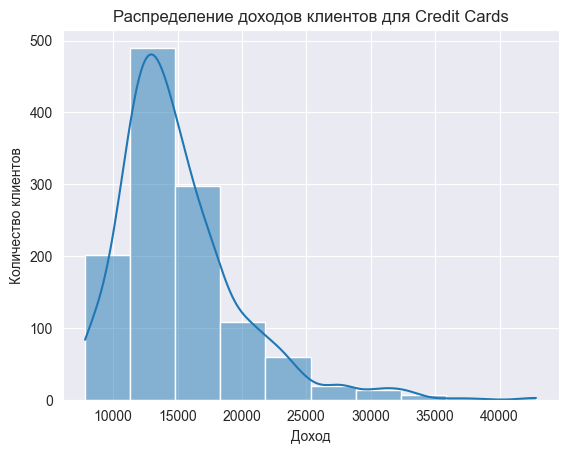

Средний доход: 15083.34
Медианный доход: 14058.08


In [17]:
# Гистограмма доходов
cc_clients['income'] = cc_clients['confirmed_income'].fillna(cc_clients['predicted_income'])

sns.histplot(cc_clients['income'], bins=10, kde=True)
plt.title('Распределение доходов клиентов для Credit Cards')
plt.xlabel('Доход')
plt.ylabel('Количество клиентов')
plt.show()

# Средняя и медианная зарплата
mean_income = cc_clients['income'].mean()
median_income = cc_clients['income'].median()

print(f"Средний доход: {mean_income:.2f}")
print(f"Медианный доход: {median_income:.2f}")


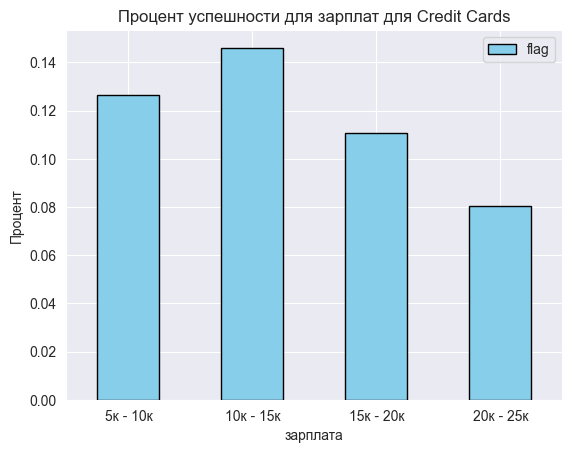

In [18]:
cc_clients['income'] = cc_clients['confirmed_income'].fillna(cc_clients['predicted_income'])
percent_by_income = cc_clients[cc_clients['income'] < 25000][['flag', 'income']].copy()
percent_by_income = percent_by_income[np.isfinite(percent_by_income['income'])]
percent_by_income['income'] = (percent_by_income['income'] // 5000 * 5000).astype(int)
percent_by_income = percent_by_income.groupby('income').mean()

ax = percent_by_income.plot(kind='bar', color='skyblue', edgecolor='black')
labels = [(str(i) + 'к - ' + str(i+5) + 'к') for i in range(5, 25, 5)]
ax.set_xticklabels(labels, rotation=0)
plt.title("Процент успешности для зарплат для Credit Cards")
plt.xlabel("зарплата")
plt.ylabel("Процент")
plt.show()

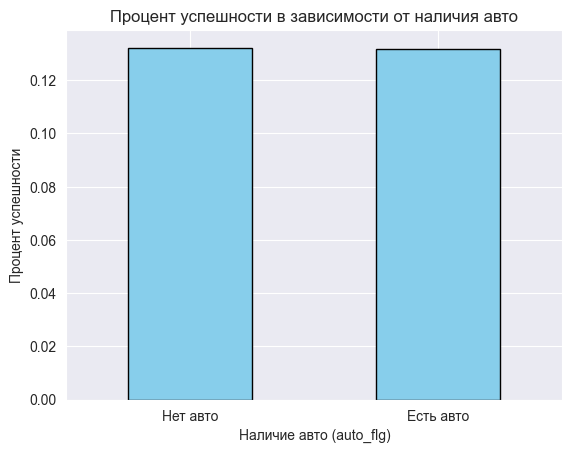

In [19]:
# Фильтрация данных и расчет среднего процента успешности по `auto_flg`
percent_by_auto = cc_clients[['auto_flg', 'flag']].copy()
percent_by_auto = percent_by_auto.dropna(subset=['auto_flg'])  # Убираем NaN из auto_flg
percent_by_auto['auto_flg'] = percent_by_auto['auto_flg'].astype(int)  # Приведение к целому

# Группировка и расчет средней успешности
percent_by_auto = percent_by_auto.groupby('auto_flg').mean()

# Построение графика
ax = percent_by_auto.plot(kind='bar', color='skyblue', edgecolor='black', legend=False)
ax.set_xticklabels(['Нет авто', 'Есть авто'], rotation=0)
plt.title("Процент успешности в зависимости от наличия авто")
plt.xlabel("Наличие авто (auto_flg)")
plt.ylabel("Процент успешности")
plt.show()


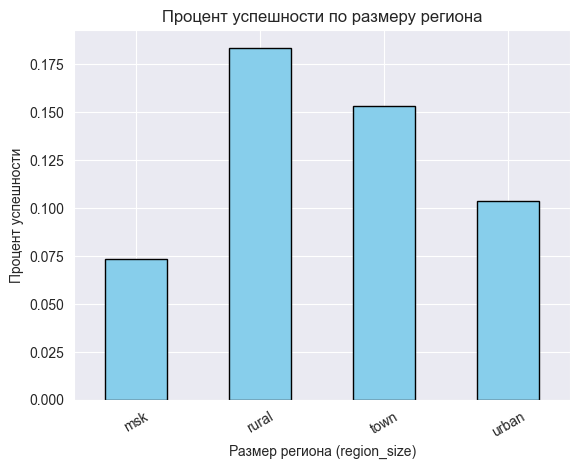

In [20]:
# Фильтрация данных и расчет среднего процента успешности по `region_size`
percent_by_region = cc_clients[['region_size', 'flag']].copy()
percent_by_region = percent_by_region.dropna(subset=['region_size'])  # Убираем NaN из region_size

# Группировка и расчет средней успешности
percent_by_region = percent_by_region.groupby('region_size').mean()

# Построение графика
ax = percent_by_region.plot(kind='bar', color='skyblue', edgecolor='black', legend=False)
ax.set_xticklabels(percent_by_region.index, rotation=30)
plt.title("Процент успешности по размеру региона")
plt.xlabel("Размер региона (region_size)")
plt.ylabel("Процент успешности")
plt.show()


NameError: name 'df' is not defined